In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import requests
import wandb
from sklearn.metrics import f1_score
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F

BATCH_SIZE = 8
images_path = "training/preprocessed_images"
groundtruths_path = "../training/groundtruth"
orig_images_path = "../training/images"

In [2]:
return_orig = False

In [3]:
class CustomDataset(Dataset):
    def __init__(self):
        self.image_files = os.listdir(images_path)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        name = self.image_files[idx][:-4]
        # print("loading " + name)

        image = torch.tensor(np.load(os.path.join(images_path, name + ".npy")), dtype=torch.float32).squeeze(0)
        groundtruth:Image = Image.open(os.path.join(groundtruths_path, name + ".png"))
        gt_tensor = torch.tensor(np.array(groundtruth),dtype=torch.float32).unsqueeze(0)/255

        if return_orig:
            orig = Image.open(os.path.join(orig_images_path, name + ".png"))
            orig = torch.tensor(np.array(orig),dtype=torch.float32)/255
        else:
            orig = torch.tensor(np.array([]),dtype=torch.float32)

        return image, gt_tensor,orig


In [4]:
# Read images
dataset = CustomDataset()

# Split the dataset
val_size = int(len(dataset) * 0.2)
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [5]:
# Create a model with a single layer
head = nn.Conv2d(768, 1, kernel_size=(1, 1), stride=(1, 1))

# Set up training
optimizer = optim.AdamW(head.parameters())
criterion = nn.BCEWithLogitsLoss()

In [6]:
use_wandb = False

def train(model, dataset, optimizer):
    model.train()
    total_loss = 0
    for x, y, _ in tqdm(dataset):
        x, y = x.cuda(), y.cuda()     
        optimizer.zero_grad()
        y_pred = model(x)
        y_pred = torch.repeat_interleave(torch.repeat_interleave(y_pred, 2, dim=2), 2, dim=3)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print("Training Loss:", total_loss / len(dataset))
    if use_wandb: wandb.log({"Train Loss": total_loss / len(dataset)})

In [7]:
def validate(model, dataset):
    model.eval()
    y_preds = np.array([])
    y_gt = np.array([])
    with torch.no_grad():
        for x, y, _ in dataset:
            x, y = x.cuda(), y.cuda()  
            # print(x.shape , y.shape)
            y_pred = model(x)
            y_pred = torch.repeat_interleave(torch.repeat_interleave(y_pred, 2, dim=2), 2, dim=3)
            y_pred = torch.sigmoid(y_pred)
            y_preds = np.concatenate((y_preds, y_pred.cpu().numpy().flatten()))
            y_gt = np.concatenate((y_gt, y.cpu().numpy().flatten()))
            
            
    y_preds = np.array(y_preds)
    y_gt = np.array(y_gt,dtype=np.bool8)
    for tresh in np.arange(0.05,0.5,0.05):        
        score = f1_score(y_gt, y_preds > tresh)
        print("Validation F1 Score for tresh",tresh,":", score)
        if use_wandb: wandb.log("Validation F1 Score for tresh "+str(tresh) +": " + str(score))


In [8]:

# Initialize wandb
if use_wandb: wandb.init(project="CIL 2023", entity="tlaborie")
if use_wandb: wandb.watch(head, log="all")

# Train and report the validation F1 score
num_epochs = 15
head = head.cuda()
for epoch in range(num_epochs):
    train(head, train_loader, optimizer)
    validate(head, val_loader)


if use_wandb: wandb.finish()


100%|██████████| 15/15 [00:15<00:00,  1.03s/it]


Training Loss: 0.5347433785597483
Validation F1 Score for tresh 0.05 : 0.2837938422676293
Validation F1 Score for tresh 0.1 : 0.2842172991725302
Validation F1 Score for tresh 0.15000000000000002 : 0.29728898136498366
Validation F1 Score for tresh 0.2 : 0.22660786330550098
Validation F1 Score for tresh 0.25 : 0.03613754833148925
Validation F1 Score for tresh 0.3 : 0.0005010870355852615
Validation F1 Score for tresh 0.35000000000000003 : 2.1597164292328413e-05
Validation F1 Score for tresh 0.4 : 0.0
Validation F1 Score for tresh 0.45 : 0.0


100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


Training Loss: 0.4582736889521281
Validation F1 Score for tresh 0.05 : 0.2838164570467945
Validation F1 Score for tresh 0.1 : 0.2980110179303401
Validation F1 Score for tresh 0.15000000000000002 : 0.37603590778376406
Validation F1 Score for tresh 0.2 : 0.4678039463510904
Validation F1 Score for tresh 0.25 : 0.16586337774223195
Validation F1 Score for tresh 0.3 : 0.0012592183139417308
Validation F1 Score for tresh 0.35000000000000003 : 0.0
Validation F1 Score for tresh 0.4 : 0.0
Validation F1 Score for tresh 0.45 : 0.0


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Training Loss: 0.4209992786248525
Validation F1 Score for tresh 0.05 : 0.2838701815950986
Validation F1 Score for tresh 0.1 : 0.2954521164708421
Validation F1 Score for tresh 0.15000000000000002 : 0.3542019723774654
Validation F1 Score for tresh 0.2 : 0.4634752022884484
Validation F1 Score for tresh 0.25 : 0.5505316831066819
Validation F1 Score for tresh 0.3 : 0.5391384384765794
Validation F1 Score for tresh 0.35000000000000003 : 0.3998228211917079
Validation F1 Score for tresh 0.4 : 0.21834282308542188
Validation F1 Score for tresh 0.45 : 0.07666934855889254


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


Training Loss: 0.398714288075765
Validation F1 Score for tresh 0.05 : 0.2858949506815513
Validation F1 Score for tresh 0.1 : 0.3197090391571623
Validation F1 Score for tresh 0.15000000000000002 : 0.40778102615778394
Validation F1 Score for tresh 0.2 : 0.5059245850871262
Validation F1 Score for tresh 0.25 : 0.5679767861901519
Validation F1 Score for tresh 0.3 : 0.5647248438870439
Validation F1 Score for tresh 0.35000000000000003 : 0.49598796479091695
Validation F1 Score for tresh 0.4 : 0.37953663724057535
Validation F1 Score for tresh 0.45 : 0.25172896151692314


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


Training Loss: 0.3832773705323537
Validation F1 Score for tresh 0.05 : 0.29084672302237863
Validation F1 Score for tresh 0.1 : 0.34389440369327934
Validation F1 Score for tresh 0.15000000000000002 : 0.44118420474479575
Validation F1 Score for tresh 0.2 : 0.5245137082479685
Validation F1 Score for tresh 0.25 : 0.5744548907172831
Validation F1 Score for tresh 0.3 : 0.5807668187369318
Validation F1 Score for tresh 0.35000000000000003 : 0.540614741073642
Validation F1 Score for tresh 0.4 : 0.470174780234729
Validation F1 Score for tresh 0.45 : 0.3780969785423073


In [9]:
validate(head, val_loader)

Validation F1 Score for tresh 0.05 : 0.29084672302237863
Validation F1 Score for tresh 0.1 : 0.34389440369327934
Validation F1 Score for tresh 0.15000000000000002 : 0.44118420474479575
Validation F1 Score for tresh 0.2 : 0.5245137082479685
Validation F1 Score for tresh 0.25 : 0.5744548907172831
Validation F1 Score for tresh 0.3 : 0.5807668187369318
Validation F1 Score for tresh 0.35000000000000003 : 0.540614741073642
Validation F1 Score for tresh 0.4 : 0.470174780234729
Validation F1 Score for tresh 0.45 : 0.3780969785423073


c:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


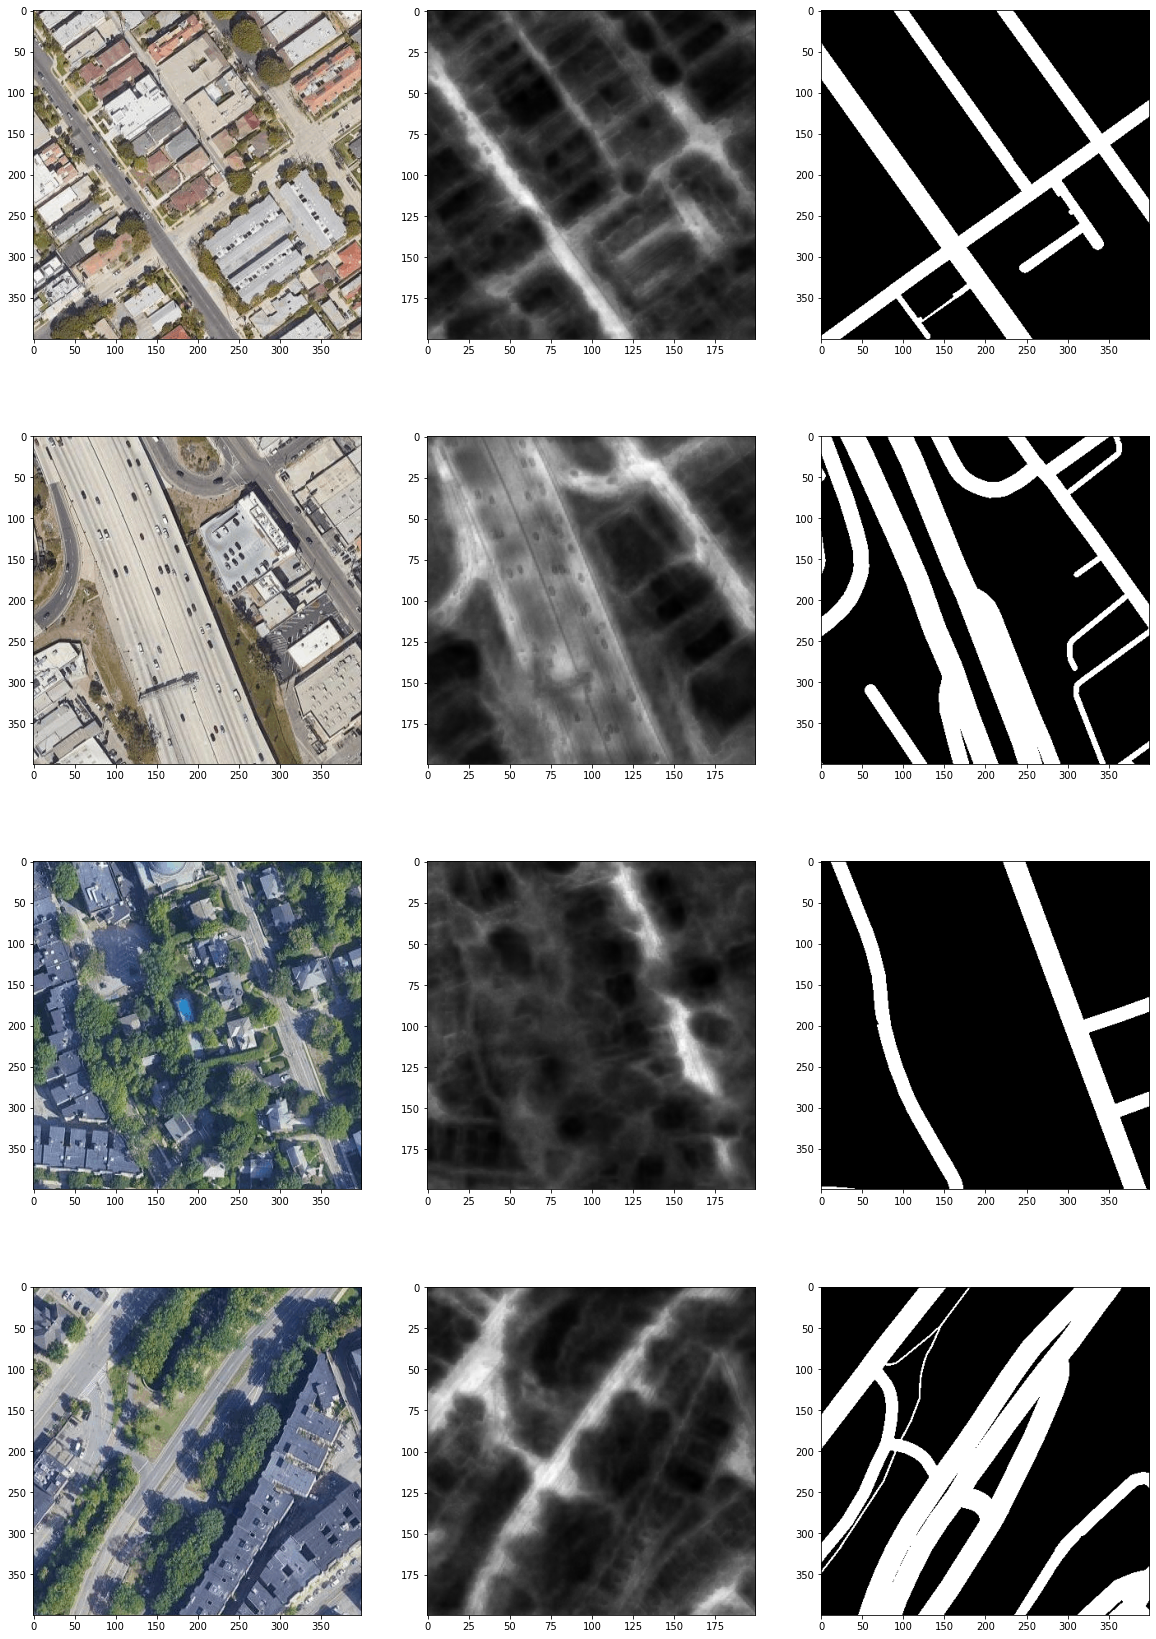

In [10]:
return_orig = True
with torch.no_grad():
    # visualize the output
    img_count = 4
    fig, ax = plt.subplots(img_count, 3, figsize=(20, 30))
    head = head.cpu()
    for i, (x, y, orig) in enumerate(val_loader):
        x = x[0]
        y = y[0]
        orig = orig[0]

        # print(x.shape)
        # print(y.shape)
        # print(orig.shape)

        pred = head(x)
        # print(pred.shape)
        pred = F.sigmoid(pred).permute(1, 2, 0)
        gt = y.permute(1, 2, 0)

        # print(orig.shape)
        # print(pred.shape)
        # print(gt.shape)

        # print(orig)
        # print(pred)
        # print(gt)

        ax[i][0].imshow(orig)
        ax[i][1].imshow(pred, cmap='gray')
        ax[i][2].imshow(gt, cmap='gray')

        if i == img_count - 1:
            break
